# Load injection - Locust - regression 1/R

Tries to better estimate the 1/R slope with 10 tests, focusing on higher lambda.

In [1]:
import os
cur_dir=os.getcwd() # save current directory to save the generated CSV files

%cd ../../..
%pwd

/home/jovyan/work


'/home/jovyan/work'

## Introduction

This notebook uses the 05-locust-g5k-iotlab.ipynb to evaluate the impact on the response time of different load injections. For that, we vary the number of **users** performing requests to CoAP servers, keeping the other parameters fixed.

Similarly to the 04-load-injection notebook, it is divided in 3 main parts.

- **Description**: creates a data frame containing the description of the different parameters of your experiment. In our case the different number of **users** in the system.
- **Running**: Reads the data frame with the description the experiment and runs each experiment. It uses papermill to call the 05-locust-g5k-iotlab.ipynb notebook with the correct parameters. Also, creates a data frame with the results.
- **Analysis**: Finally, read the output from the running phase and performs the data analysis.

Note that you can run each part **independently**. It only depends on running the first cell of this notebook to set the cur_dir properly.

## Description

Detailing the parameters used in the different experiment runs.

In [2]:
import pandas
import io
import uuid
import datetime

job_name="rsd-hackathon"

experiments=io.StringIO("""
firmware,iotlab_nodes,g5k_nodes,duration,users,N
contikimac,4,1,300,1,2
contikimac,4,1,300,50,8
""")

df = pandas.read_csv(experiments)
df = df.loc[df.index.repeat(df.N)].reset_index(drop=True)

df['exp_id'] = [str(uuid.uuid4()) for _,_ in df.iterrows()]
df['date'] = str(datetime.date.today())
df['data_dir'] = ["data/raw/%s/%s" % (i['date'], i['exp_id']) for _,i in df.iterrows()]
df['notebook_dir'] = ["%s/%s" % (cur_dir, i['exp_id']) for _,i in df.iterrows()]
df['state'] = 'created'

df = df.sample(frac=1).reset_index(drop=True) # randomize test execution
df.to_csv("%s/experiment.csv" % cur_dir)
df

firmware  iotlab_nodes  g5k_nodes  duration  users  N  \
0  contikimac             4          1       300     50  8   
1  contikimac             4          1       300     50  8   
2  contikimac             4          1       300      1  2   
3  contikimac             4          1       300     50  8   
4  contikimac             4          1       300     50  8   
5  contikimac             4          1       300     50  8   
6  contikimac             4          1       300     50  8   
7  contikimac             4          1       300      1  2   
8  contikimac             4          1       300     50  8   
9  contikimac             4          1       300     50  8   

                                 exp_id        date  \
0  c4d5903b-82ed-4a80-8c3e-8fab1b9bd055  2021-09-10   
1  466f3743-155a-4c74-96f3-1708dff632c4  2021-09-10   
2  b6c56b91-c9fe-4dd4-9b9d-3f9801cbb6c1  2021-09-10   
3  eeb7b660-cb75-4535-94e4-4951f6fe7504  2021-09-10   
4  8c386c75-61ba-4739-a596-6d128ec69b66  2021-09-10   
5  fe6bbea0-b7d4-4c6e-9c42-331f0e20e15b  2021-09-10   
6  bca2c9f1-c90a-444e-abee-15b53af6e1af  2021-09-10   
7  7d89a832-9e20-4674-80cc-a83f027e7767  2021-09-10   
8  7a9aec4f-108d-433f-868e-118a9a916866  2021-09-10   
9  1cdda205-9557-44a8-8b9a-a94af5c499c7  2021-09-10   

                                            data_dir  \
0  data/raw/2021-09-10/c4d5903b-82ed-4a80-8c3e-8f...   
1  data/raw/2021-09-10/466f3743-155a-4c74-96f3-17...   
2  data/raw/2021-09-10/b6c56b91-c9fe-4dd4-9b9d-3f...   
3  data/raw/2021-09-10/eeb7b660-cb75-4535-94e4-49...   
4  data/raw/2021-09-10/8c386c75-61ba-4739-a596-6d...   
5  data/raw/2021-09-10/fe6bbea0-b7d4-4c6e-9c42-33...   
6  data/raw/2021-09-10/bca2c9f1-c90a-444e-abee-15...   
7  data/raw/2021-09-10/7d89a832-9e20-4674-80cc-a8...   
8  data/raw/2021-09-10/7a9aec4f-108d-433f-868e-11...   
9  data/raw/2021-09-10/1cdda205-9557-44a8-8b9a-a9...   

                                        notebook_dir    state  
0  /home/jovyan/analysis/06-load-injection-locust...  created  
1  /home/jovyan/analysis/06-load-injection-locust...  created  
2  /home/jovyan/analysis/06-load-injection-locust...  created  
3  /home/jovyan/analysis/06-load-injection-locust...  created  
4  /home/jovyan/analysis/06-load-injection-locust...  created  
5  /home/jovyan/analysis/06-load-injection-locust...  created  
6  /home/jovyan/analysis/06-load-injection-locust...  created  
7  /home/jovyan/analysis/06-load-injection-locust...  created  
8  /home/jovyan/analysis/06-load-injection-locust...  created  
9  /home/jovyan/analysis/06-load-injection-locust...  created

## Running

In [5]:
import papermill as pm
import pathlib
import pandas

# read the description of the experiment
df = pandas.read_csv("%s/experiment.csv" % cur_dir)
for index, exp in df.iterrows():
    # run only recently created experiments
    if exp['state'] != 'created':
        continue

    print("Running experiment number: %d, ID: %s, firmware: %s, number of users: %d" % (index, exp['exp_id'], exp['firmware'], exp['users']))
    pathlib.Path(exp['notebook_dir']).mkdir(exist_ok=True, parents=True)

    pm.execute_notebook(
        'analysis/05-locust/05-locust-g5k-iotlab.ipynb',
        '%s/06-load-injection-locust-%d-%s.ipynb' % (exp['notebook_dir'], exp['users'], exp['exp_id']),
        cwd = "analysis/05-locust",  # going back to folder to execute notebook
        parameters = dict(
            output_dir = exp['data_dir'],
            er_image = "data/firmware/%s/er-example-server.iotlab-m3" % exp['firmware'],
            br_image = "data/firmware/%s/border-router.iotlab-m3" % exp['firmware'],
            free_resources = False if index < len(df.index) - 1 else True, #free resources in last experiment
            duration = exp['duration'],
            users = exp['users'],
            iotlab_nodes = exp['iotlab_nodes'],
            iotlab_site = 'grenoble',
            g5k_nodes = exp['g5k_nodes'],
        )
    )
    
    # change and save new state
    df.at[index, 'state'] = 'executed'
    df.to_csv("%s/experiment.csv" % cur_dir)


Running experiment number: 4, ID: 8c386c75-61ba-4739-a596-6d128ec69b66, firmware: contikimac, number of users: 50


Executing:   0%|          | 0/54 [00:00<?, ?cell/s]

Running experiment number: 5, ID: fe6bbea0-b7d4-4c6e-9c42-331f0e20e15b, firmware: contikimac, number of users: 50


Executing:   0%|          | 0/54 [00:00<?, ?cell/s]

Running experiment number: 6, ID: bca2c9f1-c90a-444e-abee-15b53af6e1af, firmware: contikimac, number of users: 50


Executing:   0%|          | 0/54 [00:00<?, ?cell/s]

Running experiment number: 7, ID: 7d89a832-9e20-4674-80cc-a83f027e7767, firmware: contikimac, number of users: 1


Executing:   0%|          | 0/54 [00:00<?, ?cell/s]

Running experiment number: 8, ID: 7a9aec4f-108d-433f-868e-118a9a916866, firmware: contikimac, number of users: 50


Executing:   0%|          | 0/54 [00:00<?, ?cell/s]

Running experiment number: 9, ID: 1cdda205-9557-44a8-8b9a-a94af5c499c7, firmware: contikimac, number of users: 50


Executing:   0%|          | 0/54 [00:00<?, ?cell/s]

Parse and save results.

In [7]:
import pandas
import os.path

# where to save the results from experiment
results_filename = "%s/results.csv" % cur_dir
out = None
results_full_filename = "%s/results_full.csv" % cur_dir
out_full = None


# read the description of the experiment
df = pandas.read_csv("%s/experiment.csv" % cur_dir)
for index, exp in df.iterrows():
    if exp['state'] != 'executed':
        continue

    # read and save output of this test
    temp = pandas.read_csv(exp['data_dir'] + "/enoslib_stats.csv")
    temp['exp_id'] = exp['exp_id']
    temp['users'] = exp['users']
    temp['N'] = exp['N']    
    out = pandas.concat([out, temp])
    
    temp = pandas.read_csv(exp['data_dir'] + "/enoslib_stats_history.csv")
    temp['exp_id'] = exp['exp_id']
    temp['users'] = exp['users']
    temp['N'] = exp['N']
    out_full = pandas.concat([out_full, temp])
    
out.to_csv(results_filename)
out_full.to_csv(results_full_filename)    

## Analysis

Read dataframe with the results of all experiments.

Locust already gives us aggregated results about main metrics. Let's use them.

In [2]:
%load_ext rpy2.ipython
import pandas

out = pandas.read_csv("%s/results.csv" % cur_dir)
out_full = pandas.read_csv("%s/results_full.csv" % cur_dir)
out

Unnamed: 0        Type                                           Name  \
0            0  coapclient  [2001:660:5307:3142::a172]:5683/sensors/gyros   
1            1  coapclient  [2001:660:5307:3142::a269]:5683/sensors/gyros   
2            2  coapclient  [2001:660:5307:3142::b679]:5683/sensors/gyros   
3            3         NaN                                     Aggregated   
4            0  coapclient  [2001:660:5307:3142::a172]:5683/sensors/gyros   
5            1  coapclient  [2001:660:5307:3142::a269]:5683/sensors/gyros   
6            2  coapclient  [2001:660:5307:3142::b679]:5683/sensors/gyros   
7            3         NaN                                     Aggregated   
8            0  coapclient  [2001:660:5307:3142::a269]:5683/sensors/gyros   
9            1         NaN                                     Aggregated   
10           0  coapclient  [2001:660:5307:3142::a172]:5683/sensors/gyros   
11           1  coapclient  [2001:660:5307:3142::a269]:5683/sensors/gyros   
12           2  coapclient  [2001:660:5307:3142::b679]:5683/sensors/gyros   
13           3         NaN                                     Aggregated   
14           0  coapclient  [2001:660:5307:3142::a172]:5683/sensors/gyros   
15           1  coapclient  [2001:660:5307:3142::a269]:5683/sensors/gyros   
16           2  coapclient  [2001:660:5307:3142::b679]:5683/sensors/gyros   
17           3         NaN                                     Aggregated   
18           0  coapclient  [2001:660:5307:3142::a172]:5683/sensors/gyros   
19           1  coapclient  [2001:660:5307:3142::a269]:5683/sensors/gyros   
20           2  coapclient  [2001:660:5307:3142::b679]:5683/sensors/gyros   
21           3         NaN                                     Aggregated   
22           0  coapclient  [2001:660:5307:3142::a172]:5683/sensors/gyros   
23           1  coapclient  [2001:660:5307:3142::a269]:5683/sensors/gyros   
24           2  coapclient  [2001:660:5307:3142::b679]:5683/sensors/gyros   
25           3         NaN                                     Aggregated   
26           0  coapclient  [2001:660:5307:3142::a269]:5683/sensors/gyros   
27           1         NaN                                     Aggregated   
28           0  coapclient  [2001:660:5307:3142::a172]:5683/sensors/gyros   
29           1  coapclient  [2001:660:5307:3142::a269]:5683/sensors/gyros   
30           2  coapclient  [2001:660:5307:3142::b679]:5683/sensors/gyros   
31           3         NaN                                     Aggregated   
32           0  coapclient  [2001:660:5307:3142::a172]:5683/sensors/gyros   
33           1  coapclient  [2001:660:5307:3142::a269]:5683/sensors/gyros   
34           2  coapclient  [2001:660:5307:3142::b679]:5683/sensors/gyros   
35           3         NaN                                     Aggregated   

    Request Count  Failure Count  Median Response Time  Average Response Time  \
0            1885              0                   810            1351.554377   
1            2624              0                   920            1417.793064   
2             787              0                   720            2844.171537   
3            5296              0                   860            1606.180514   
4            2675              0                   820            1149.263551   
5             890              0                   840            3607.510112   
6            1666              0                   800            1367.106843   
7            5231              0                   820            1636.888549   
8             272              0                   100             102.900735   
9             272              0                   100             102.900735   
10           2137              0                   920            1322.267197   
11            989              0                   850            3195.493428   
12           2147              0                   800            1183.819748   
13           5273   

### Mean response time

Plot mean response time, 

Using the aggregated data provided by locust.

R[write to console]: 
Attaching package: ‘dplyr’


R[write to console]: The following objects are masked from ‘package:stats’:

    filter, lag


R[write to console]: The following objects are masked from ‘package:base’:

    intersect, setdiff, setequal, union




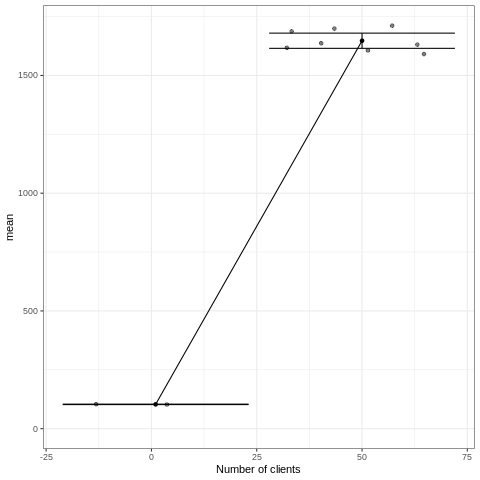

In [3]:
%%R -i out
library(dplyr)
library(ggplot2)

out %>% filter(Name == "Aggregated") %>% group_by(users) %>% summarize(mean = mean(`Average Response Time`), sd = sd(`Average Response Time`), se = sd/sqrt(n())) %>%
ggplot(aes(users, mean)) + geom_point() + geom_line() +
    geom_errorbar(aes(ymin=mean - 2*se, ymax= mean + 2*se)) +
    geom_jitter(data=out[out$Name == "Aggregated",], aes(users, `Average Response Time`), alpha=.5) +
    xlab("Number of clients") + ylim(0, NA) + theme_bw()

### Response time ($R$) against $\lambda$

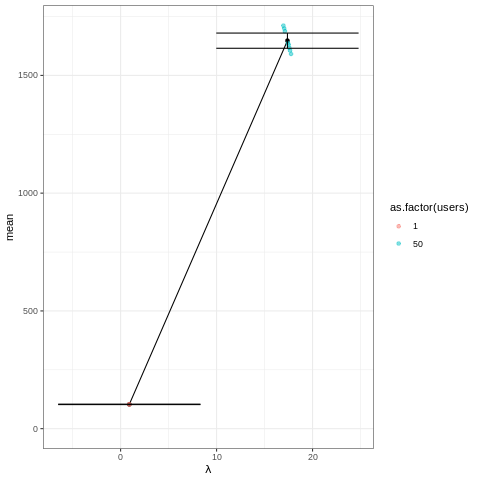

In [4]:
%%R -i out
out %>% filter(Name == "Aggregated") %>% group_by(users) %>% summarize(lambda = mean(`Requests/s`), mean = mean(`Average Response Time`), sd = sd(`Average Response Time`), se = sd/sqrt(n())) %>%
ggplot(aes(lambda, mean)) + geom_point() + geom_line() +
    geom_point(data=out[out$Name == "Aggregated",], aes(`Requests/s`, `Average Response Time`, color=as.factor(users)), alpha=.5) +
    geom_errorbar(aes(ymin=mean - 2*se, ymax= mean + 2*se)) +
    xlab(expression(lambda))+ ylim(0, NA)  + theme_bw()

### $1/R$ against $\lambda$

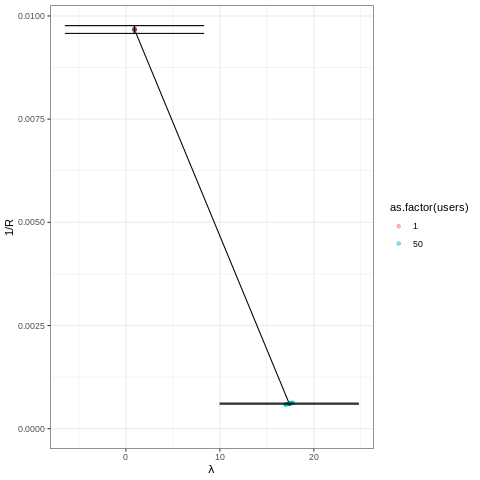

In [5]:
%%R -i out

out %>% filter(Name == "Aggregated") %>% group_by(users) %>% summarize(lambda = mean(`Requests/s`), mean = mean(`Average Response Time`), sd = sd(`Average Response Time`), se = sd/sqrt(n())) %>%
ggplot(aes(lambda, 1/mean)) + geom_point() + geom_line() +
    geom_point(data=out[out$Name == "Aggregated",], aes(`Requests/s`, 1/`Average Response Time`, color=as.factor(users)), alpha=.5) +
    geom_errorbar(aes(ymin=1/(mean - 2*se), ymax=1/(mean + 2*se))) +
    ylab(expression("1/R")) + xlab(expression(lambda)) + ylim(0, NA) + theme_bw()

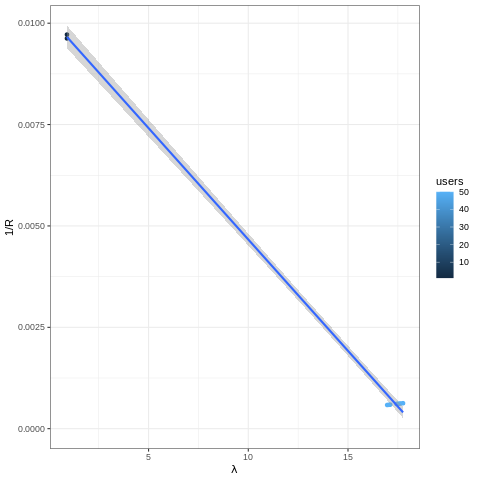

In [6]:
%%R -i out

out %>% filter(Name == "Aggregated") %>%
ggplot(aes(`Requests/s`, 1/`Average Response Time`, color=users)) + geom_point() +
    geom_smooth(method="lm", formula="y~x") +
    ylab(expression("1/R")) + xlab(expression(lambda)) + ylim(0, NA) + theme_bw()

In [7]:
%%R -i out

model = lm("1/`Average Response Time` ~ `Requests/s`", data=out[out$Name == "Aggregated",])
summary(model)


Call:
lm(formula = "1/`Average Response Time` ~ `Requests/s`", data = out[out$Name == 
    "Aggregated", ])

Residuals:
       Min         1Q     Median         3Q        Max 
-2.560e-04 -1.301e-04  4.468e-05  1.036e-04  2.258e-04 

Coefficients:
               Estimate Std. Error t value Pr(>|t|)    
(Intercept)   1.016e-02  1.280e-04   79.37 7.08e-13 ***
`Requests/s` -5.493e-04  8.228e-06  -66.76 2.82e-12 ***
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1

Residual standard error: 0.0001716 on 8 degrees of freedom
Multiple R-squared:  0.9982,	Adjusted R-squared:  0.998 
F-statistic:  4457 on 1 and 8 DF,  p-value: 2.821e-12

